In [ ]:
import sys
!{sys.executable} -m pip install gym -U
!{sys.executable} -m pip install gym[box2D] -U
!{sys.executable} -m pip install flax -U

In [2]:
import gym
import numpy as np

import jax
import jax.numpy as jnp
from jax import grad, jit, random

from flax import linen as nn           # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

import numpy as np
import matplotlib.pyplot as plt
import optax                           # Optimizers
import pickle

from IPython import display
from itertools import count

In [3]:
def _simulate_full_episode(agent, rm=None):
    """
        Simulate a full episode
    """
    # Sim init
    env = gym.make("LunarLander-v2", render_mode=rm)
    observation, info = env.reset()
    
    # Data init
    total_reward = 0
    observations = []
    actions = []
    rewards = []

    for i in count():
        # Simulate an episode
        action = agent.policy(observation)
        
        # Log the observation and action taken
        observations.append(observation)
        actions.append(action)
        
        observation, reward, terminated, truncated, info = env.step(action)
        
        # Log the reward received, scaled to make value training easier
        rewards.append(reward * 0.01)

        total_reward += reward

        if terminated or truncated:
            break

    env.close()
    return observations, actions, rewards, total_reward, i+1


def visualize(agent, num_sim=1, rm="human"):
    """
        Wrapper to simulate an arbitrary number of episodes and fetch the reward
    """
    return [_simulate_full_episode(agent, rm)[3] for i in range(num_sim)]

def simulate(agent):
    return _simulate_full_episode(agent)

def evaluate_fitness(agent, eps=5):
    scores = [_simulate_full_episode(agent)[3] for i in range(5)]
    return np.mean(scores), np.median(scores)

In [4]:
class GA_DNN(nn.Module):
    """
        GA Approximator Function
        Same as PG but without softmax
    """

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=4)(x)

        return x

def init_model(model):
    """
        Semi-hardcoded init model
    """
    key1, key2 = random.split(random.PRNGKey(0))
    dummy_input = random.normal(key1, (8,))
    params = model.init(key2, dummy_input)
    return params

In [5]:
# class GA:
#     def __init__(self):
#         model = GA_DNN()

#         self.model = model
#         self.params = init_model(model)

#     def policy(self, observation):
#         return int(jnp.argmax(self.model.apply(self.params, observation)))

#     def offspring(self):
#         pass

class GAWrap:
    """
        Wrapper to keep things consistent but we only care about the params
    """
    def __init__(self, params):
        self.params = params
        @jit
        def policy(params, observation):
            return np.argmax( GA_DNN().apply(params, observation) )
        self.policy_func = policy
    
    def policy(self, observation):
        jm= self.policy_func(self.params, observation)
        return int(np.array(jm))

# @jit
def noise(shape):
    # print(shape)
    ret = np.random.normal(0, 5E-4, shape)
    choice = np.random.choice(shape[0], shape[0]//5, replace=False)
    for i in choice:
        ret[i] = 0
    # print(ret)
    return ret

# @jit
def mutate(param):
    return jax.tree_util.tree_map(
        lambda p: p + noise(p.shape)
    , param)

def sample_mutate(parents, num_child):
    n = len(parents)
    # Preserve the good genes
    next_gen = [*parents]
    selected = np.random.randint(n, size=num_child-len(parents))
    for i in selected:
        next_gen.append(mutate(parents[i]))
    
    return next_gen

Training setup:

In [ ]:
MAX_GEN = 10000

first = init_model(GA_DNN())

# Init the elite
elite = first
elite_score = evaluate_fitness(GAWrap(first))[0]

pop_size = 500
sample_size = 50

population = sample_mutate([first], pop_size)
# Progenitor score
elite_scores = [elite_score]
gen_mean = [elite_score]
i = 0

Load training setup:

In [8]:
MAX_GEN = 10000
pop_size = 500
sample_size = 50


parents, elite_scores, gen_mean, elite, elite_score = load_progress()
population = sample_mutate(parents, pop_size)
i = len(gen_mean)

Start/Resume Training:

In [53]:
for i in range(i, MAX_GEN):
    fitness = np.zeros((pop_size,))
    for ind, agent in enumerate(population):
        reward = np.mean( visualize(GAWrap(agent), 3, None) )
        fitness[ind] = reward 
    
    sorted = np.argsort(fitness)
    # Somehow performance is degrading overtime?
    top = sorted[-sample_size:] # Top performers
    # top = sorted[:sample_size] # Bottom performers

    parents = [ population[i] for i in top ]
    population = sample_mutate(parents, pop_size)

    # Tracking the top performer
    peak_score = fitness[top[-1]]
    mean_score = np.mean(fitness)

    elite_scores.append(peak_score)
    gen_mean.append(mean_score)

    # DB Trace
    print(i, peak_score, mean_score)

    # Tracking the best agent
    if peak_score > elite_score:
        contender = population[ top[-1] ]
        # Victory march range, higher threshold
        if peak_score > 150:
            peak_score = evaluate_fitness(GAWrap(contender), 5)[0]
            if peak_score > elite_score:
                elite_score = peak_score
                elite = contender
        else:
            elite_score = peak_score
            elite = contender

    if elite_score >= 200:
        print("Found an elite")
        break

    if i%10 == 9:
        store_progress()

201 181.72713898311608 -88.79243401069121
202 148.21536212298975 -86.6321990609787
203 158.43697442634343 -98.29524507977665
204 160.15101832681322 -89.50895164243272
205 208.5046504645658 -89.68664391292279
206 149.6917630743623 -94.12451887207426
207 172.97456845978854 -97.291806762933
208 148.36537406970757 -96.19022287778836
209 214.4435232808596 -83.82464392869198
210 186.36588712050548 -92.8499374831276
211 183.00901625466076 -81.12251146242065
212 229.17410577962218 -85.16493242168642
213 163.59089840563436 -76.06860295840923
214 198.88821847309495 -68.21942272898139
215 229.20580163572265 -77.78672135146677
216 155.28816638079218 -78.80652941419953
217 151.38745478973883 -74.92238160220558
218 163.8338050221723 -85.52149376569989
219 227.82146694920706 -71.62545246692264
220 219.88687991825938 -72.57295336107397
221 166.17698375572706 -84.38338120420033
222 263.098214211743 -74.1435450742731
223 215.96529186902288 -74.83156318343113
224 177.58888944613577 -74.22960256828871
225

KeyboardInterrupt: ignored

Plotting:

Text(0, 0.5, 'Episode Reward')

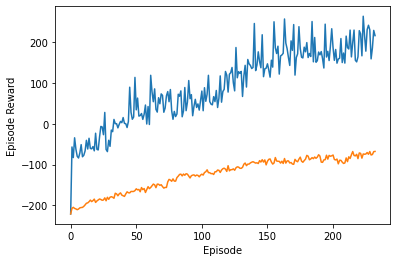

In [58]:
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

n = len(elite_scores)
episode = [i for i in range(n)]
cum_r = get_running_stat(elite_scores, 10)
cum_l = get_running_stat(gen_mean, 10)
# plot rewards
# plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, elite_scores)
plt.plot(episode, gen_mean)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')



In [7]:
def store_progress(filename="ga_run1_data"):
    with open(f"/content/drive/MyDrive/pickle/{filename}.pkl", "wb") as f:
        # pickle.dump((population, elite_scores, gen_mean, elite, elite_score), f)
        pickle.dump((parents, elite_scores, gen_mean, elite, elite_score), f)

def load_progress(filename="ga_run1_data"):
    with open(f"/content/drive/MyDrive/pickle/{filename}.pkl", "rb") as f:
        return pickle.load(f)

In [ ]:
store_progress()

In [57]:
np.max([evaluate_fitness(GAWrap(elite), 5)[0] for i in range(10)])
# elite_score

28.740533014196775

In [ ]:
agent_bank.append((agent, elite_scores, gen_mean ))

In [ ]:
j = 0
agent, elite_scores, gen_mean = agent_bank[i]

i = len(reward_data)

KeyboardInterrupt: ignored

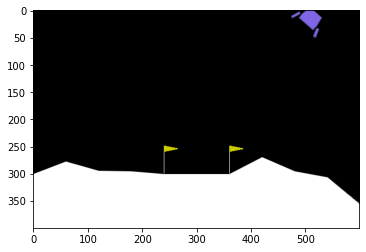

In [ ]:
from IPython import display

env = gym.make("LunarLander-v2", render_mode='rgb_array')
obs, info = env.reset()

img = plt.imshow(env.render())

agent = GAWrap(elite)

for i in range(5):
    while True:
        action = agent.policy(obs)
        obs, reward, done, done2, info = env.step(action)

        screen = env.render()
        img.set_data(screen)
        display.clear_output(wait=True)
        display.display(plt.gcf())

        if done:
            obs, info = env.reset()
            break
env.close()